# Simulations

In [ ]:
import dill
from model import Model
from network_utils import generate_network_variant, calculate_degree_gini
import networkx as nx
import numpy.random as rd
import numpy as np
import pandas as pd
import os
from tqdm.auto import tqdm
from joblib import Parallel, delayed

In [58]:
with open('empirical_networks/pud_final.pkl', 'rb') as f:
    net = dill.load(f)
print(f"{net.number_of_nodes()=}")
print(f"{net.number_of_edges()=}")

net.number_of_nodes()=312
net.number_of_edges()=583


In [ ]:
def simulation_variant(
    id: int,
    net: nx.DiGraph,
    variation_method: str,
    n_steps: int = 10**4,
    network_folder: str | None = None,
) -> dict:
    """Runs a simulation on a variant network, setting the bandit parameters randomly.
    
    Parameters
    ----------
    net: nx.DiGraph
        The original directed network to vary.
    variation_method: str
        The variation method to use, either "equalize" or "densify".
    
    Returns
    -------
    dict
        A dictionary with the simulation results, including also bandit features and network features. 
    """
    uncertainty = rd.uniform(0.0001, 0.001)
    n_experiments = rd.randint(50, 1000)
    proportion_edges = 1/3 * rd.rand()
    n_edges = int(proportion_edges * net.number_of_edges())
    if variation_method == "equalize":
        net_variant = generate_network_variant(
            net, 
            n_edges,
            target_degree_dist="uniform",
            keep_density_fixed=True,
        )
        net_model = Model(
            net_variant, 
            n_experiments=n_experiments,
            uncertainty=uncertainty,
            
        )
        net_model.run_simulation(n_steps=n_steps)
        conclusion = net_model.conclusion
        clustering_average = np.average(
            list(nx.clustering(net_variant).values())
        )
        degree_gini = calculate_degree_gini(net_variant)
        degree_average = np.average(
            list(dict(net_variant.out_degree()).values())
        )
        n_isolates = len(list(nx.isolates(net_variant)))
        if network_folder is not None:
            with open(f"{network_folder}/network_{id}.pkl", "wb") as f:
                dill.dump(net_variant, f)
            
        return {
            "id": id,
            "conclusion": conclusion, 
            "uncertainty": uncertainty, 
            "n_experiments": n_experiments,
            "proportion_edges": proportion_edges, 
            "variation_method": variation_method,
            # "network_variant": net_variant,
            "degree_average": degree_average,
            "degree_gini": degree_gini,
            "clustering_average": clustering_average,
            "n_isolates": n_isolates,
        }
        
    if variation_method == "densify":
        net_variant = generate_network_variant(
            net, 
            n_edges,
            target_degree_dist="original",
            keep_density_fixed=False,
        )
        net_model = Model(
            net_variant, 
            n_experiments=n_experiments,
            uncertainty=uncertainty,
        )
        net_model.run_simulation(n_steps=n_steps)
        conclusion = net_model.conclusion
        clustering_average = np.average(
            list(nx.clustering(net_variant).values())
        )
        degree_gini = calculate_degree_gini(net_variant)
        degree_average = np.average(
            list(dict(net_variant.out_degree()).values())
        )
        n_isolates = len(list(nx.isolates(net_variant)))
        if network_folder is not None:
            with open(f"{network_folder}/network_{id}.pkl", "wb") as f:
                dill.dump(net_variant, f)
        
        return {
            "id": id,
            "conclusion": conclusion, 
            "uncertainty": uncertainty, 
            "n_experiments": n_experiments,
            "proportion_edges": proportion_edges, 
            "variation_method": variation_method,
            # "network_variant": net_variant,
            "degree_average": degree_average,
            "degree_gini": degree_gini,
            "clustering_average": clustering_average,
            "n_isolates": n_isolates
        }    
    raise ValueError(
        f"Variation method '{variation_method=}' invalid."
    )

In [19]:
def simulation_study(
    net: nx.DiGraph,
    variation_method: str,
    n_simulations: int, 
    n_steps: int,
    file: str,
    network_folder: str | None,
) -> None:
    if network_folder is not None:
        if os.path.exists(network_folder) == False:
            os.makedirs(network_folder)
    file_dir = os.path.dirname(file)
    if os.path.exists(file_dir) == False:
        os.makedirs(file_dir)
    
    study_params = [
        {
            "id": id, 
            "net": net, 
            "variation_method": variation_method, 
            "n_steps": n_steps, 
            "network_folder": network_folder
        } 
        for id in range(n_simulations)
    ]
    data = list(tqdm(Parallel(return_as="generator", n_jobs=-2)(
        delayed(simulation_variant)(**params) 
        for params in study_params
    ), total=n_simulations, desc="Progress"))
    
    df = pd.DataFrame(data)
    df.to_csv(file)       

In [ ]:
# joblib.Parellel can return a generator which can be processed one-by-one 
# instead of creating a list. This would drastically reduce memory (in case it is an issue)
# def process(generator):
#     for value in generator:
#         with open("test.csv", "wb") as f:
#             line = f"{value}"
#             f.write(line)

In [ ]:
simulation_study(
    net, 
    variation_method="equalize",
    n_simulations=1_000,
    n_steps=10_000,
    file="data/simulation_equalize.csv",
    network_folder="data/networks_equalize",
)

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
simulation_study(
    net, 
    variation_method="densify",
    n_simulations=1_000,
    n_steps=10_000,
    file="data/simulation_densify.csv",
    network_folder="data/networks_densify",
)

# Plotting

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np

def plot_scatter_matrix(X, y, color=None, max_cols=3, filename=None, hex_colors=None):
    """
    Plots scatterplots of all columns in DataFrame X against the target vector y,
    with an adjustable number of columns per row and centering if the last row is incomplete.

    Parameters:
    X : DataFrame
        Input data with multiple columns.
    y : array-like
        Target variable data.
    color : array-like or str, optional
        Color data for the scatter points. If None, a default color is used.
        If str, it's used as a single color for all points.
        If array-like, it's used for coloring points (categorical or continuous).
    max_cols : int
        Maximum number of columns per row in the subplot grid.
    filename : str, optional
        If provided, the plot will be saved to this file.
    hex_colors : list of str, optional
        List of hex color codes to use for categorical data.
    """
    columns = X.columns
    target_name = y.columns[0]
    plot_count = len(columns)
    nrows = (plot_count + max_cols - 1) // max_cols

    fig = plt.figure(figsize=(5 * max_cols, 5 * nrows))
    m = max_cols
    gs = gridspec.GridSpec(nrows, m * max_cols)
    axs = []

    # Determine color handling
    if color is None:
        color_data = '#ab0b00'
        cmap = None
    elif isinstance(color, str):
        color_data = color
        cmap = None
    else:
        color_data = np.asarray(color)
        if np.issubdtype(color_data.dtype, np.number):
            cmap = 'viridis'
        else:
            # For categorical data, use provided hex colors or default to 'tab10'
            unique_values = np.unique(color_data)
            n_colors = len(unique_values)
            if hex_colors and len(hex_colors) >= n_colors:
                cmap = ListedColormap(hex_colors[:n_colors])
            else:
                cmap = plt.cm.get_cmap('tab10')
            color_data = np.array([np.where(unique_values == val)[0][0] for val in color_data])

    # Create subplots
    for idx, col in enumerate(columns):
        row = idx // max_cols
        col_idx = idx % max_cols
        last_row = nrows - 1

        # Apply centering offset only if the last row is incomplete
        if row == last_row and (plot_count % max_cols != 0):
            off = (m * (max_cols - (plot_count % max_cols))) // 2
        else:
            off = 0

        ax = plt.subplot(gs[row, m * col_idx + off: m * (col_idx + 1) + off])
        axs.append(ax)

        scatter = ax.scatter(X.iloc[:, idx], y, c=color_data, cmap=cmap, alpha=0.5)

        ax.set_xlabel(columns[idx])
        if col_idx == 0:
            ax.set_ylabel(target_name)

    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename, dpi=300, transparent=True)
    plt.show()


In [10]:
rename_dict = {
    # 'n_agents': 'Number of Agents',
    # 'p_rewiring': 'Probability of Rewiring',
    'uncertainty': 'Problem Easiness',
    'n_experiments': 'Number of Experiments',
    'conclusion': 'Share of correct agents', # is this CORRECT ?!!?!?!?
    # 'convergence_step': 'Steps until convergence (log)',
    #'share_of_correct_agents_at_convergence':'Share of correct agents',
    'degree_average': 'Mean Degree',
    'clustering_average':'Clustering Coeff.',
    'degree_average': 'Average Degree',
    'degree_gini': 'Degree Gini Coeff.',
    'ba_degree':'BA-Degree',
    'avg_path_length': 'Avg. Path Length',
    'degree_entropy': 'Degree Entropy',
    'diameter': 'Diameter',
    'reachability_dominator_set_size': 'Reach. Dominator SS',
    'reachability_dominator_set_ratio': 'Reach. Dominator SR',
    'condensation_graph_size': 'Cond. Graph Size',
    'condensation_graph_ratio': 'Cond. Graph Ratio',
}
to_plot_columns = [
    'degree_average', 
    'degree_gini',
    'clustering_average',
    'uncertainty',
    'n_experiments',
]
to_model_columns = ['degree_gini_coefficient'	,'approx_average_clustering_coefficient', 'degree_entropy', 'reachability_dominator_set_size','reachability_dominator_set_ratio', 'condensation_graph_size','condensation_graph_ratio','uncertainty',	'n_experiments'	]

methods_columns = dict()
# methods_columns['randomization'] = ['degree_gini_coefficient'	,'approx_average_clustering_coefficient',
#                     'uncertainty',	'n_experiments']
methods_columns['equalize'] = [
    'degree_gini',
    'clustering_average',
    'uncertainty',
    'n_experiments',
]
# methods_columns['densify_fixed'] = ['degree_gini_coefficient'	,'approx_average_clustering_coefficient',
#                     'uncertainty',	'n_experiments']
methods_columns['densify'] = [
    'degree_gini',
    'clustering_average',
    'uncertainty',
    'n_experiments',
    'degree_average']

Plots for method: equalize
The length of the data is: 1000


C:\Users\heind\AppData\Local\Temp\ipykernel_23608\821874386.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=rename_dict, inplace=True)


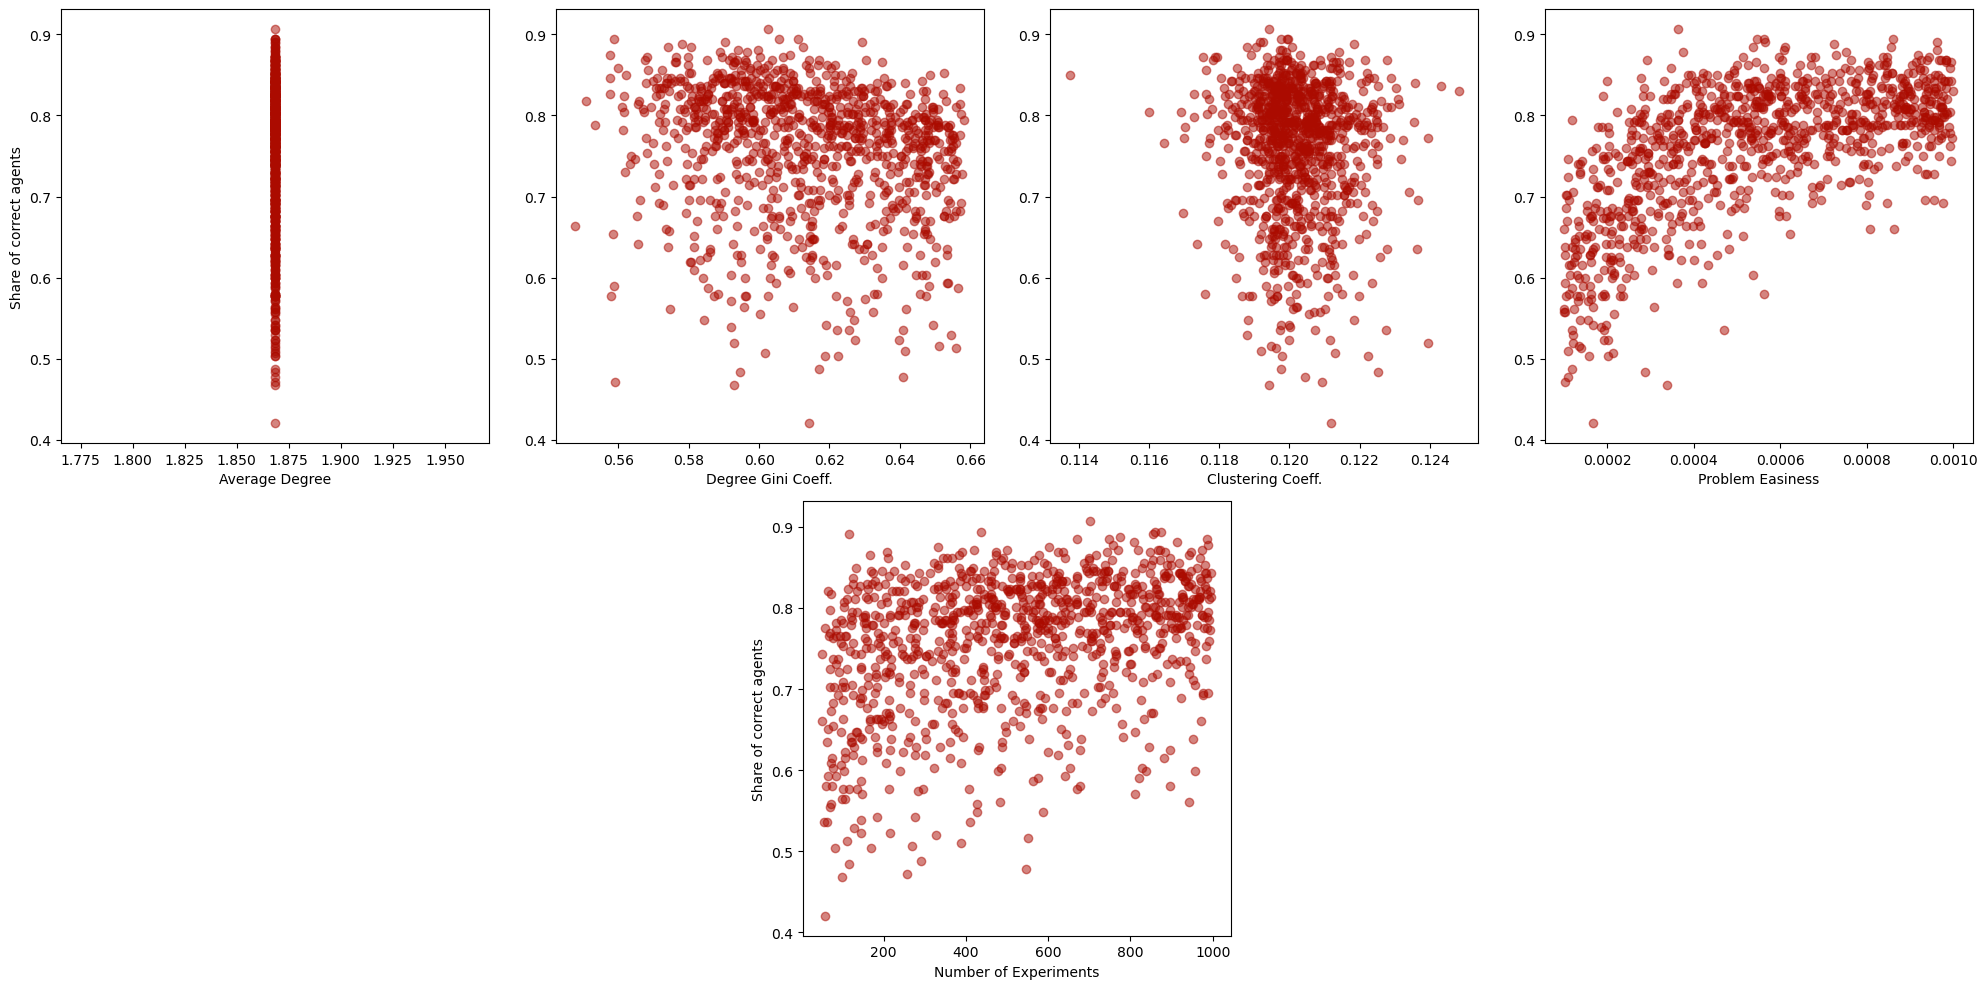

--------------------------------------------------------------------------------
Plots for method: densify
The length of the data is: 1000


C:\Users\heind\AppData\Local\Temp\ipykernel_23608\821874386.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=rename_dict, inplace=True)


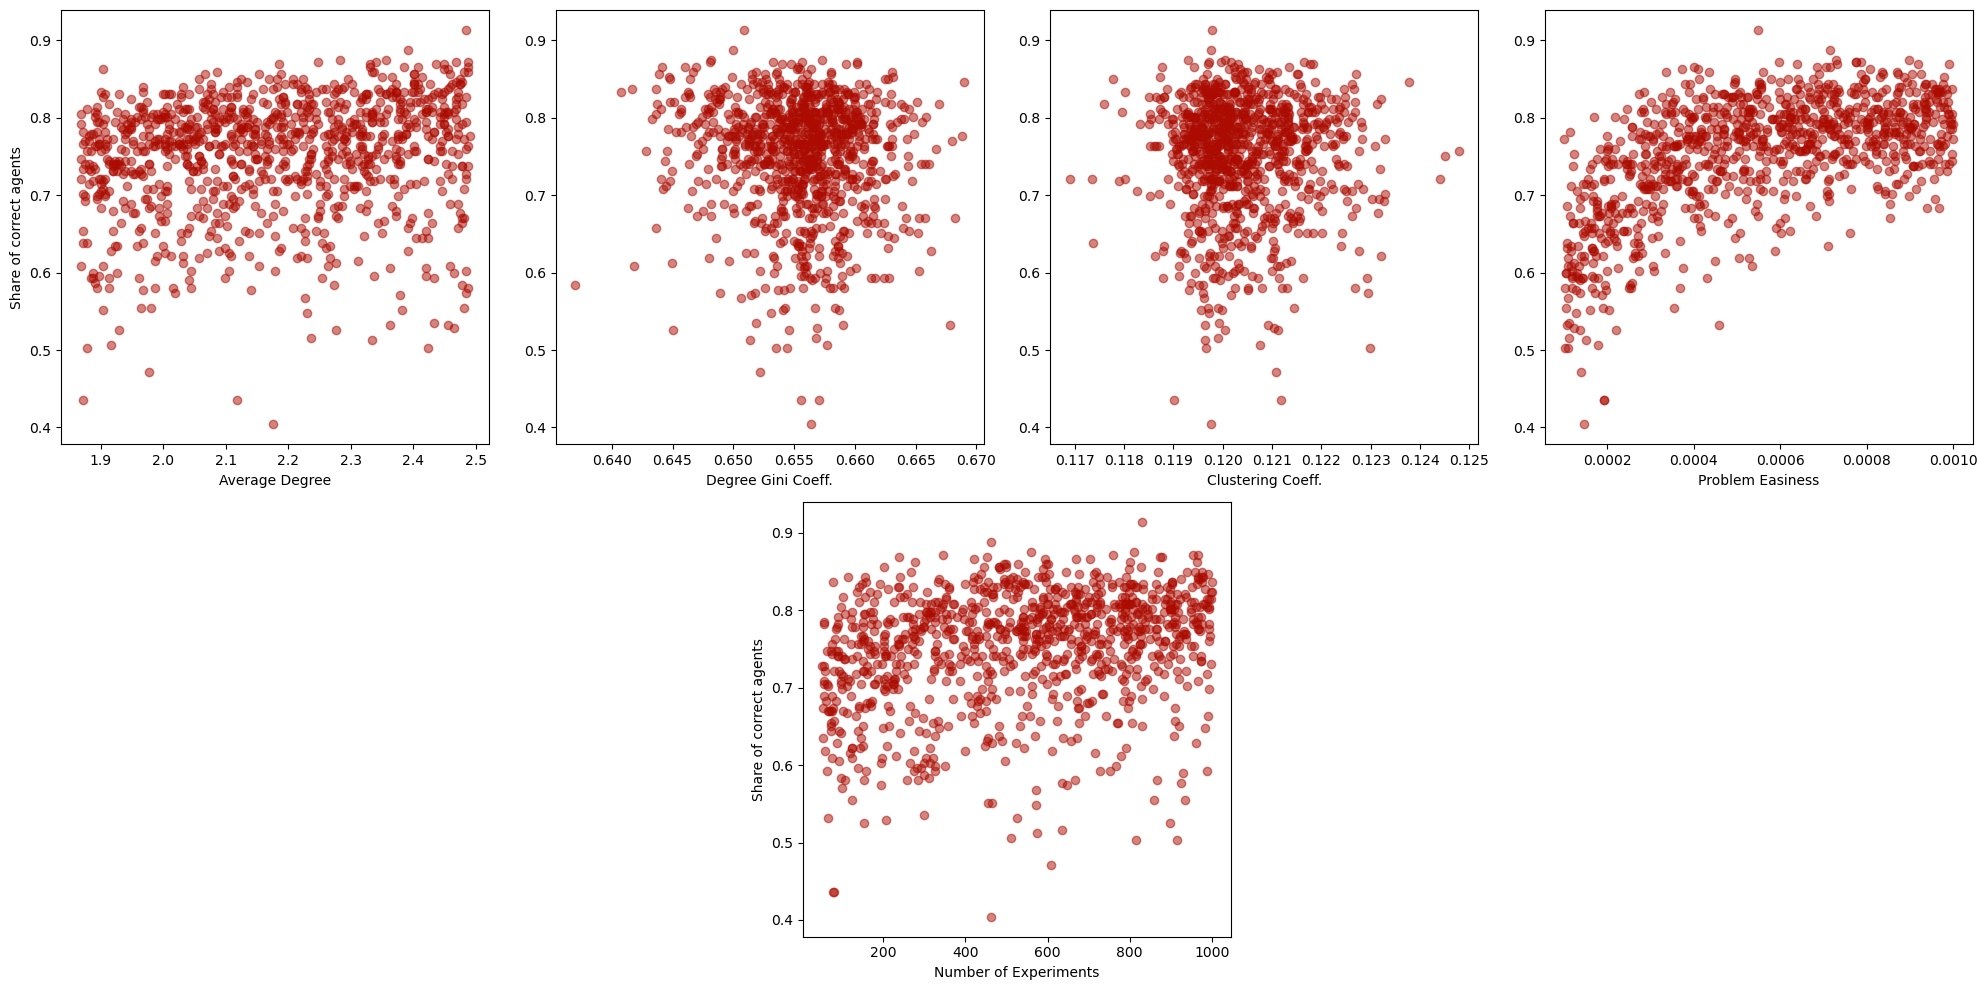

--------------------------------------------------------------------------------


In [ ]:
methods = ['equalize','densify']#,'densify_fixed']
for method in methods:
  print(f'Plots for method: {method}')
  results_path = f"data/simulation_{method}.csv"
  results_df = pd.read_csv(results_path)
  print(f'The length of the data is: {len(results_df)}')
  X = results_df[to_plot_columns]
  y = pd.DataFrame(results_df['conclusion'])
  X.rename(columns=rename_dict, inplace=True)
  y.rename(columns=rename_dict, inplace=True)
  plot_scatter_matrix(X, y, color='#ab0b00', max_cols=4, filename=None)#,hex_colors=['#d9d9d9','#ab0b00'])
  # y = pd.DataFrame(np.log(combined_results_df['convergence_step']))
  # X.rename(columns=rename_dict, inplace=True)
  # y.rename(columns=rename_dict, inplace=True)
  # plot_scatter_matrix(X, y, color='#ab0b00', max_cols=4, filename=None)#,hex_colors=['#d9d9d9','#ab0b00'])
  # y = pd.DataFrame(np.log(combined_results_df['convergence_step']))
  # # X.rename(columns=rename_dict, inplace=True)
  # y.rename(columns=rename_dict, inplace=True)
  # plot_scatter_matrix(X, y, color='#ab0b00', max_cols=3, filename=None)
  print('-'*80)

# Data analysis

In [52]:
import statsmodels.api as sm
import pandas as pd
from scipy.stats import zscore
from IPython.display import display

In [61]:
methods = ["equalize", "densify"]

for method in methods:
  # Get data
  results_path = f"data/simulation_{method}.csv"
  results_df = pd.read_csv(results_path)
  
  predictors = methods_columns[method]
  dependent_variable = "conclusion"
  
  X = results_df[predictors]
  y = results_df[[dependent_variable]].rename(columns=rename_dict)

  # Add constant and fit model
  X_const = sm.add_constant(X)
  model = sm.OLS(y, X_const).fit()
  print("="*60)
  print(f'Linear regression for method: {method}')
  print("="*60)
  print(f"R² = {round(model.rsquared, 3)} (coefficient of determination)")
  print("="*60)
  
  # Compute descriptive statistics
  stats = (X.select_dtypes(include='number')
            .agg(['mean', 'std'])     # sample std (ddof=1)
            .T
            .rename(columns={'mean':'Mean', 'std':'Std'}))
  print('-'*60)
  print('Descriptive statistics')
  print('-'*60)
  print(f'- The length of the data is: {len(results_df)}')
  display(stats)
  
  # p-values
  p_values = model.pvalues[1:]
  
  # Effect size (Cohen's f^2)
  # Cohen’s rules of thumb: 0.02 (small), 0.15 (medium), 0.35 (large).
  r2_full = model.rsquared
  f2_values = []
  for col in X.columns:
      X_reduced = X.drop(columns=[col])
      X_reduced = sm.add_constant(X_reduced)
      model_reduced = sm.OLS(y, X_reduced).fit()
      r2_reduced = model_reduced.rsquared
      f2 = (r2_full - r2_reduced) / (1 - r2_full)
      f2_values.append(f2)
  f_squared = pd.Series(f2_values, index=X.columns)

# Usage:
# X = df[['predictor1', 'predictor2', ...]]
# y = df['outcome']
# X_const = sm.add_constant(X)
# model = sm.OLS(y, X_const).fit()
# f2 = cohens_f_squared(model, X, y)

  f_squared = (model.tvalues[1:] ** 2) / model.df_resid
  
  def interpret_f2(f2):
    if f2 >= 0.35:
        return 'Large'
    elif f2 >= 0.15:
        return 'Medium'
    elif f2 >= 0.02:
        return 'Small'
    else:
        return 'Negligible'
   
  # Compute standardized coefficients
  # Standardize using zscore, and fit on standardized data
  X_std = zscore(X, ddof=1)
  y_std = zscore(y, ddof=1)
  model_std = sm.OLS(y_std, sm.add_constant(X_std)).fit()
  coef_normalized = model_std.params[1:]
  
  predictors_df = pd.DataFrame({
    'Normalized Coef': coef_normalized,
    'f²': f_squared,
    'f² Interpretation': f_squared.apply(interpret_f2),
    'p-value': model.pvalues[1:].round(4),
  }, index=X.columns)
  predictors_df = predictors_df.sort_values(by='f²', ascending=False)
  
  print('-'*60)
  print('Strength of predictors')
  print('-'*60)
  display(predictors_df)

  # Print full summary
  # print('-'*60)
  # print('Full summary')
  # print('-'*60)
  # print(model.summary())

Linear regression for method: equalize
R² = 0.55 (coefficient of determination)
------------------------------------------------------------
Descriptive statistics
------------------------------------------------------------
- The length of the data is: 1000


Mean         Std
degree_gini           0.612923    0.025032
clustering_average    0.120194    0.001142
uncertainty           0.000541    0.000264
n_experiments       521.733000  272.501495

------------------------------------------------------------
Strength of predictors
------------------------------------------------------------


Normalized Coef        f² f² Interpretation  p-value
uncertainty                0.631530  0.883233             Large   0.0000
n_experiments              0.346710  0.266547            Medium   0.0000
degree_gini               -0.209180  0.094197             Small   0.0000
clustering_average        -0.063396  0.008646        Negligible   0.0034

Linear regression for method: densify
R² = 0.452 (coefficient of determination)
------------------------------------------------------------
Descriptive statistics
------------------------------------------------------------
- The length of the data is: 1000


Mean         Std
degree_gini           0.655505    0.004555
clustering_average    0.120410    0.001039
uncertainty           0.000547    0.000259
n_experiments       535.348000  273.040334
degree_average        2.176404    0.179081

------------------------------------------------------------
Strength of predictors
------------------------------------------------------------


Normalized Coef        f² f² Interpretation  p-value
uncertainty                0.593765  0.641098             Large   0.0000
n_experiments              0.283564  0.146192             Small   0.0000
degree_average             0.197739  0.069052             Small   0.0000
degree_gini               -0.043424  0.003352        Negligible   0.0683
clustering_average        -0.016471  0.000494        Negligible   0.4838

# Network visualization

In [11]:
import dill
from model import Model
from pyvis.network import Network
from networkx.algorithms import community
import networkx as nx
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from networkx.drawing.layout import forceatlas2_layout
from networkx.algorithms import community as nx_comm
import numpy as np
import graphviz

In [12]:
with open('empirical_networks/pud_final.pkl', 'rb') as f:
    net = dill.load(f)

Graphviz visualization saved as 'network_graphviz.png'


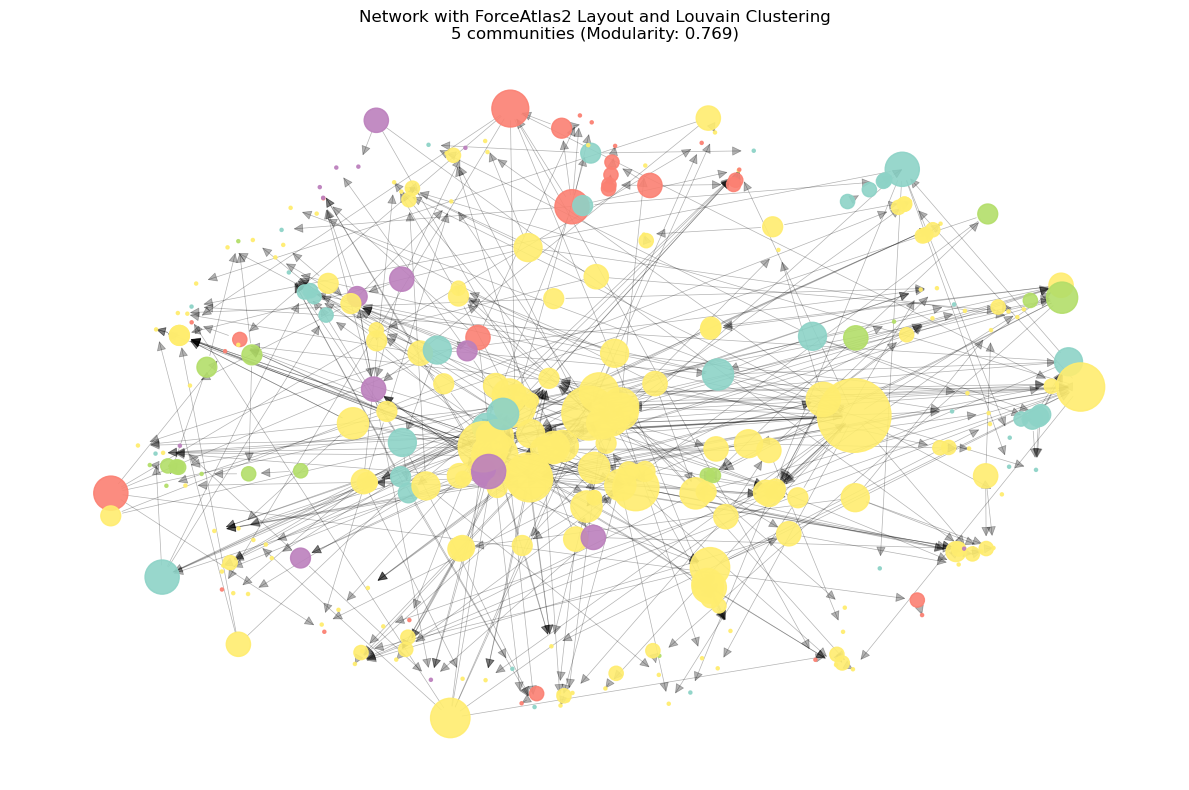

Found 5 communities
Modularity score: 0.769


In [49]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.layout import forceatlas2_layout
import networkx.algorithms.community as nx_comm
import numpy as np
import graphviz

# Calculate node sizes proportional to out-degree
out_degrees = dict(net.out_degree())
node_sizes = [out_degrees[node] * 100 + 5 for node in net.nodes()]
node_sizes_dict = {node: out_degrees[node] * 100 + 5 for node in net.nodes()}

# Detect communities using Louvain method
communities = nx_comm.louvain_communities(net.to_undirected(), resolution=0.1, seed=42)

# Assign cluster colors
color_map = plt.cm.Set3(np.linspace(0, 1, len(communities)))
color_hex = ['#{:02x}{:02x}{:02x}'.format(int(r*255), int(g*255), int(b*255)) for r, g, b, _ in color_map]

node_to_community = {}
for idx, comm in enumerate(communities):
    for node in comm:
        node_to_community[node] = idx

# Increase repulsion between communities
for u, v in net.edges():
    if node_to_community[u] != node_to_community[v]:
        net[u][v]["weight"] = -1000    # weaken cross-cluster edges
    else:
        net[u][v]["weight"] = 100    # strengthen internal edges

# Apply ForceAtlas2 layout
pos = forceatlas2_layout(
    net,
    max_iter=100,
    pos=None,
    gravity=0.01,
    node_size=node_sizes_dict,
    weight="weight",
    seed=42  # For reproducibility
)

# Create Graphviz graph
dot = graphviz.Digraph(format='png')
dot.attr(rankdir='LR', overlap='false', splines='curved')

# Add nodes with colors based on community
def safe_id(x):
    return f"n{abs(hash(x))}"
    
for node in net.nodes():
    comm_idx = node_to_community[node]
    dot.node(safe_id(node), color=color_hex[comm_idx], style='filled', 
             width=str(np.sqrt(node_sizes[list(net.nodes()).index(node)] / 100) / 10))

# Count edges for bundling (edge width proportional to edge count)
edge_counts = {}
for u, v in net.edges():
    edge_counts[(u, v)] = edge_counts.get((u, v), 0) + 1

# Add edges with width proportional to edge count
for (u, v), count in edge_counts.items():
    dot.edge(safe_id(u), safe_id(v), penwidth=str(count * 0.5), color='gray', alpha='0.5')

# Render Graphviz visualization
dot.render('network_graphviz', cleanup=True)
print("Graphviz visualization saved as 'network_graphviz.png'")

# Also create matplotlib visualization for comparison
plt.figure(figsize=(12, 8))
node_colors = [color_map[node_to_community[node]] for node in net.nodes()]

nx.draw_networkx_nodes(net, pos, node_color=node_colors, 
                       node_size=node_sizes, alpha=0.9
                      )

# Draw edges with width proportional to edge count
for (u, v), count in edge_counts.items():
    nx.draw_networkx_edges(net, pos, [(u, v)], alpha=0.3, 
                           arrowsize=15, width=count * 0.5)

# Calculate and display modularity
modularity = nx_comm.modularity(net.to_undirected(), communities)
plt.title(f"Network with ForceAtlas2 Layout and Louvain Clustering\n{len(communities)} communities (Modularity: {modularity:.3f})")
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Found {len(communities)} communities")
print(f"Modularity score: {modularity:.3f}")

In [30]:


G = network

# Detect communities
communities = community.greedy_modularity_communities(G)
modularity_classes = {}
for i, com in enumerate(communities):
    for node in com:
        modularity_classes[node] = i

# Size nodes by out-degree
out_degrees = dict(G.out_degree())
node_sizes = {node: 3 * degree + 2 for node, degree in out_degrees.items()}

# Assign node attributes
for node in G.nodes():
    G.nodes[node]['group'] = modularity_classes[node]
    G.nodes[node]['size'] = node_sizes[node]
    G.nodes[node]['title'] = f'Node {node}<br>Community {modularity_classes[node]}<br>Out-degree {out_degrees[node]}'

# Create pyvis network
net = Network(notebook=True, cdn_resources='remote')
net.from_nx(G)
net.show_buttons(filter_=['physics'])
net.show("communities.html")

NameError: name 'network' is not defined

In [6]:


net = Network(notebook=True, cdn_resources="remote")

net.from_nx(network)
net.show_buttons("physics")
net.show("network.html")


network.html


In [4]:
m.run_simulation(number_of_steps=10**4, show_bar=True, histories=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

# Archive

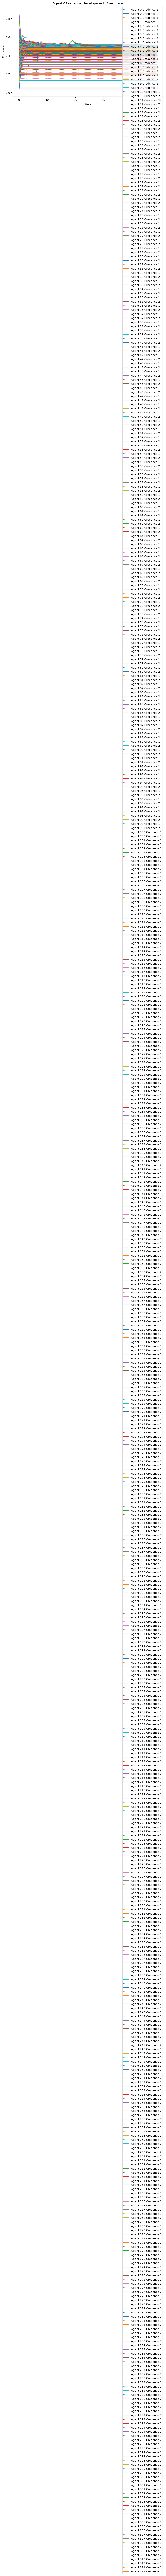

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

# Parameters: change `update_every` to 1 to update every step or to 10 to update every 10 steps
n_steps = 50
update_every = 10  # update the figure every N steps

m = Model(network, n_experiments=100, uncertainty=0.001)
# we'll store each agent's credence history as lists
credence_history_1 = [[] for _ in m.agents]
credence_history_2 = [[] for _ in m.agents]

plt.ion()
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.tab10.colors  # up to 10 distinct colors

for step in range(n_steps):
    # advance the model one step
    m.step()
    # record credences for all agents
    for idx, agent in enumerate(m.agents):
        credence_history_1[idx].append(agent.credences[0])
        credence_history_2[idx].append(agent.credences[1])

    # update the figure every `update_every` steps (or on the final step)
    if (step + 1) % update_every == 0 or step == n_steps - 1:
        clear_output(wait=True)
        ax.clear()
        for agent_idx, (cred1, cred2) in enumerate(zip(credence_history_1, credence_history_2)):
            color = colors[agent_idx % len(colors)]
            ax.plot(range(len(cred1)), cred1, linestyle=':', color=color)
            ax.plot(range(len(cred2)), cred2, linestyle='-', color=color, label=f'Agent {agent_idx}')

        ax.set_xlabel('Step')
        ax.set_ylabel('Credence')
        ax.set_title(f"Agents' Credence Development (step {step + 1})")
        # show legend only when there are not too many agents
        if len(m.agents) <= 10:
            ax.legend(fontsize='small')
        display(fig)
        # short pause so the frontend updates smoothly
        plt.pause(0.001)

plt.ioff()
